<a href="https://colab.research.google.com/github/mauriciodev/pymwv/blob/master/pymwv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from osgeo import ogr
import math
import matplotlib.pyplot as plt

In [5]:
class MWVD:
    def ApoloniusCircle(self, s1, s2, w1, w2, extent):
        """
        Calculates the Apollonius circle for two sites (s1, s2) with weights (w1, w2).

        Args:
          s1: Tuple (x, y) representing the coordinates of the first site.
          s2: Tuple (x, y) representing the coordinates of the second site.
          w1: Weight of the first site.
          w2: Weight of the second site.
          extent: ogr.Geometry representing the extent of the area.

        Returns:
          ogr.Geometry: The Apollonius circle as an ogr.Geometry object.
        """
        s1x, s1y = s1
        s2x, s2y = s2

        if w1 == w2:  # Regular Voronoi
            mx = (s1x + s2x) / 2.
            my = (s1y + s2y) / 2.
            dx = s1x - s2x
            dy = s1y - s2y
            d = extent.GetBoundary().Length()
            curve = ogr.Geometry(ogr.wkbLineString)

            if dy != 0:
                m = math.atan(-1. * (dx / dy))
                curve.AddPoint_2D(-d * math.cos(m) + mx, -d * math.sin(m) + my)
                curve.AddPoint_2D(d * math.cos(m) + mx, d * math.sin(m) + my)
            else:
                curve.AddPoint_2D(mx, -d + my)
                curve.AddPoint_2D(mx, d + my)

            shortCurve = curve.Intersection(extent)
            diff = extent.GetBoundary().Difference(curve)
            boundary = diff.GetGeometryRef(1)
            endPoint = boundary.GetPoint(0)
            boundary.AddPoint_2D(endPoint[0], endPoint[1])

            ring = ogr.Geometry(ogr.wkbLinearRing)
            for point in boundary.GetPoints():
                ring.AddPoint_2D(point[0], point[1])
            ring.AddGeometry(boundary)

            domBoundary = ogr.Geometry(ogr.wkbPolygon)
            domBoundary.AddGeometry(ring)

        else:  # Weighted Voronoi
            den=1./(w1*w1-w2*w2);
            cx=(w1*w1*s2x-w2*w2*s1x)*den
            cy=(w1*w1*s2y-w2*w2*s1y)*den
            #print('Center:', cx, cy)
            d= math.sqrt(((s1x-s2x)*(s1x-s2x) + (s1y-s2y)*(s1y-s2y)))
            r=w1*w2*d*den
            #print("Radius:",r)
            if (r<0): r=r*-1
            #creating the circle boundary from 3 points
            arc= ogr.Geometry(ogr.wkbCircularString)
            arc.AddPoint_2D(cx+r,cy)
            arc.AddPoint_2D(cx-r,cy)
            arc.AddPoint_2D(cx+r,cy)
            #creating the circle polygon
            domBoundary=ogr.Geometry(ogr.wkbCurvePolygon)
            domBoundary.AddGeometry(arc)

        # Create ogr.Geometry from tuple for intersection check
        s1_geom = ogr.Geometry(ogr.wkbPoint)
        s1_geom.AddPoint_2D(*s1)

        if s1_geom.Intersects(domBoundary):
            return domBoundary.Intersection(extent)
        else:
            return extent.Difference(domBoundary)

    def getMWVLayer(self, sites, extent):
        """
        Calculates the Multiplicatively Weighted Voronoi Diagram for a set of sites.

        Args:
          sites: List of dictionaries, each with keys 'p' (tuple of x,y coordinates)
                 and 'w' (weight).
          extent: ogr.Geometry representing the extent of the area.

        Returns:
          list: A list of polygons, each represented as a list of (x, y) tuples.
        """
        polygons = []
        for site1 in sites:
            dominance = extent
            for site2 in sites:
                if site1 != site2:
                    twoSitesDominance = self.ApoloniusCircle(site1['p'], site2['p'], site1['w'], site2['w'], extent)
                    dominance = dominance.Intersection(twoSitesDominance)

            # Extract polygon boundary points
            boundary = dominance.GetBoundary()
            polygon = []
            for i in range(boundary.GetPointCount()):
                x, y, _ = boundary.GetPoint(i)
                polygon.append((x, y))
            polygons.append(polygon)
        return polygons


In [3]:
def create_extent(points):
    """
    Creates an extent polygon from a list of points.

    Args:
      points: A list of (x, y) tuples representing the points.

    Returns:
      ogr.Geometry: An ogr.Geometry object representing the extent polygon.
    """
    minx = min(p[0] for p in points)
    miny = min(p[1] for p in points)
    maxx = max(p[0] for p in points)
    maxy = max(p[1] for p in points)

    # Create a slightly larger extent for buffering
    dx = (maxx - minx) / 10.
    dy = (maxy - miny) / 10.
    minx -= dx
    miny -= dy
    maxx += dx
    maxy += dy

    ring = ogr.Geometry(ogr.wkbLinearRing)
    ring.AddPoint(minx, miny)
    ring.AddPoint(minx, maxy)
    ring.AddPoint(maxx, maxy)
    ring.AddPoint(maxx, miny)
    ring.AddPoint(minx, miny)

    extent = ogr.Geometry(ogr.wkbPolygon)
    extent.AddGeometry(ring)
    return extent

[[(0.6, 0.6), (0.6, 3.1126428394299883), (1.2186356643521516, 2.9714432860165814), (2.3606625608392626, 0.6), (0.6, 0.6)], [(2.3606625608392626, 0.6), (1.223501903483414, 2.9613384363396777), (1.6384340130675807, 3.1353105168661837), (2.6506182995218257, 3.4797128604182825), (4.445320347487413, 2.5769423775420512), (3.49327507561819, 0.6), (2.3606625608392626, 0.6)], [(4.411918942123078, 2.5075836446274207), (4.8394978518656435, 2.63678471508706), (5.4, 2.8493551409819595), (5.4, 0.6), (3.49327507561819, 0.6), (4.411918942123078, 2.5075836446274207)], [(4.8394978518656435, 2.63678471508706), (4.518925291347588, 2.539917640881138), (2.607735405128111, 3.5012838010225065), (2.799848721585431, 3.962670994610289), (3.0716146398498942, 4.534192115847554), (3.371225291177893, 5.091620643966734), (3.561300457774457, 5.4), (5.4, 5.4), (5.4, 2.8493551409819595), (4.8394978518656435, 2.63678471508706)], [(1.6384340130675807, 3.1353105168661837), (1.2373920319681704, 2.9671622675049623), (0.6, 3.

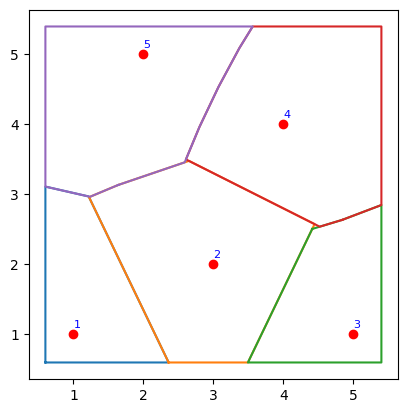

In [6]:
points = [
    (1, 1),
    (3, 2),
    (5, 1),
    (4, 4),
    (2, 5)
]
weights = [1.11, 1.12, 1.13, 1.1, 1.2]

sites = [{'p': p, 'w': w} for p, w in zip(points, weights)]
extent = create_extent(points)

mwvd = MWVD()
polygons = mwvd.getMWVLayer(sites, extent)

# Plotting the polygons
fig, ax = plt.subplots()
print(polygons)
for polygon in polygons:
    xs, ys = zip(*polygon)
    ax.plot(xs, ys, '-')

# Plot the sites
for i, point in enumerate(points):
    ax.plot(point[0], point[1], 'ro')
    ax.text(point[0], point[1]+0.1, f'{i+1}', fontsize=8, color='blue')

ax.set_aspect('equal')

plt.show()